# $KFDA$ (с различными ядрами). Реализация алгоритма, примеры работы, анализ точности.


## Содержание
1. [Библиотеки и общие фунцкции](#lib)
2. [FDA](#Fda)
    2.1 [Функции для реализации FDA](#Fda)
    2.2 [Пример работы алгоритма](#ex0)
    2.2 [Пример FDA на Dataset1](#ex1)
    2.3 [CircleData.FDA не работает](#c0)
3. [Переxод в пространство большей размерности](#c1)
4. [KFDA](#kfda)
    4.1 [Реализация класса KFDA](#kfda)
    4.2 [KFDA. Пример CircleData](#c1)
    4.3 [Сравнение работы KFDA и FDA на Dataset2](#ex2)

5. [Параметры ядра](#par0)
    5.1 [RBF KFDA при различных пар-ах на Dataset2](#par1)
    5.2 [Определение наилучших параметров для RBF ядра](#par2)
6. [KFDA для многоклассового случая](#multi0)
   6.1. [Пример работы на Iris Dataset](#multi0)
7. [Построение ROC-кривых для KFDA](#roc)
8. [Cравнительная таблица точности классификаторов](#ac)

<a id="lib"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import scipy as sc
import math
import scipy.spatial.distance
from  scipy import stats, linalg, exp, interp
from sklearn.cross_validation import train_test_split
from sklearn import datasets, svm
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.cm as cm
import scipy.io as sio
import nbimporter
from numpy import linalg
from sklearn import model_selection, datasets, metrics, svm
from sklearn.preprocessing import StandardScaler,  label_binarize
from sklearn.svm import SVC
import matplotlib.lines as mLines
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import mpl_toolkits.mplot3d as plt3d
from itertools import cycle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
def get_data(dataset): #считывает данные из sklearn/datasets
    X = dataset.data[:,:]
    y = dataset.target
    y = np.array([y]).T
    return X, y
def readmat(st): #считывает данные из файла в формате mat
    matcontents = sio.loadmat(st)
    X = matcontents['X']
    Y = matcontents['y']
    return X, Y

def plotData(X,y,edgecolor = None, optpos = 'oy',optneg='xk',optP3 = '^b'): #для визуализации исходного 2D dataset в 2D
    """"
    input: X - матрица признаков объектов, размера nx2
           y - вектор nx1 меток классов объектов(классов либо два, либо три)
           optpos, optneg, optP3 - marker и color для данных 1го, 2го и 3го класса соответственно     
    output:
           График X[:,1] от X[:,2], точки с метками классов
    """
    labels = np.unique(y)
    pos = X[np.nonzero(y == labels[0])[0],:];
    neg = X[np.nonzero(y == labels[1])[0],:];
    plt.axis('equal')
    p1,  = plt.plot(pos[:,0],pos[:,1],optpos,markeredgecolor = edgecolor,  label = 'First class' )
    p2, =plt.plot(neg[:,0],neg[:,1], optneg, markeredgecolor = edgecolor, label = 'Second class')
    if len(labels) == 3:
        P3 = X[np.nonzero(y == labels[2])[0],:];
        p3, = plt.plot(P3[:,0], P3[:,1], optP3, markeredgecolor = edgecolor, label = 'Third class')
        plt.legend(handles = [p1, p2, p3], loc = 4)
    else:
        plt.legend(handles = [p1, p2], loc = 2)
    import warnings
    

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Реализация $FDA$ <a id="Fda"></a>
Для наглядности сначала, реализуем алгоритм для линейного $KFDA$ (FDA). В дальнейшем в этом алгоритме отпадет надобность, т.к. классификатор $KFDA$ будет реализовывать $FDA$ при линейном ядре.

In [2]:
def FisherVectorProject(X,y): #Возращает наилучший вектор для проекции, определямый алг Фишера
    """
    input: X - матрица признаков объектов nxk 
           y - вектор меток классов nx1
    output:W_fda - вектор Фишера, наилучший для проектирования данных, размером nx1
    """
    #Размерность пространства
    dimension = X.shape[1]
    # label -массив индентификаторов классов
    labels = np.unique(y)
    Sw = np.zeros((dimension,dimension))
    Sb = np.zeros((dimension,dimension))
    mu_total = np.mean(X, axis = 0)
    for i in range (0,2):
        Xi = X[np.nonzero(y == labels[i])[0],:]
        n = Xi.shape[0]
        mu_i = np.mean(Xi, axis = 0)
        XMi = Xi - mu_i
        Sw = Sw + np.dot(XMi.T, XMi )
        MiM =  np.array([mu_i - mu_total])
        Sb = Sb + n*np.dot(MiM.T,MiM)
    S = np.dot(np.linalg.pinv(Sw),Sb)
    #S = np.linalg.solve(Sw, Sb)
    #Cобственный вектор, cooтветсвующий макс собств значению:
    eigenValues, eigenVectors = scipy.linalg.eig(S)
    maxInd =np.argmax(eigenValues)
    Max = eigenVectors[:,maxInd]
    W_fda = np.array([Max]).T
    return W_fda
def FisherDataProject(X, W, mu_total): #Проекция точек из X на вектор W
    """
    input: X - матрица признаков объектов nxk 
           W - вектор проектирования nx1
           mu_total усредненый вектор признаков объектов из X, 1xk
    output:X_proj -матрица спроектированных на W векторов признаков объектов, nxk
    """
    X_proj = np.dot(X,W)
    X_proj = np.dot(X_proj,W.T)
    X_proj =  X_proj + mu_total
    return X_proj
def FisherDataRed(X,W): #Проекция точек из 2D в 1D на вектор W
    """
    input: X - матрица признаков объектов nxk 
           W - вектор проектирования nx1
    output:X_red -вектор значений спроектированных в одномерное пр-во, cонаправленное с  W,
                                                          векторов признаков объектов, nx1
    """
    X_red = np.zeros(( X.shape[0], 1))
    for i in range(0, X.shape[0]):
        X_red[i, 0] = np.dot(X[i,:],W)
    return X_red

def FDACl(X,y): #Создает классификационную модель для Фишеровского алгоритма
    """
    input: X - матрица признаков объектов nxk 
           y - вектор меток классов nx1
    output: 
            W_fda - вектор Фишера, наилучший для проектирования данных, размером nx1
            labels - массив меток классов 1xc (c-число классов)
            mu_red0, mu_red1 - средние значение признаков 1го и 2го класса,соответственно, после проекции в 1D(на W)
    """
    W = FisherVectorProject(X,y)[:,0] #вектор проекции
    labels = np.unique(y)
    mu0 = np.array([np.mean(X[np.nonzero(y == labels[0])[0],:], axis = 0)])

    mu1 = np.array([np.mean(X[np.nonzero(y == labels[1])[0],:], axis = 0)])
    mu1_red = FisherDataRed(mu1,W)
    mu0_red = FisherDataRed(mu0,W)
    return W, mu0_red, mu1_red, labels
def FDApred(X,W,mu0_red,mu1_red, labels):
    """
    input: X - матрица признаков объектов, для которых необх предсказать класс, mxk
           W_fda - вектор Фишера, наилучший для проектирования данных, размером nx1
           labels - массив меток классов 1xc (c-число классов)
           mu_red0, mu_red1 - средние значение признаков 1го и 2го класса,соответственно, после проекции в 1D(на W)
    output:
           y - вектор предсказанный меток классов для объектов из X, mx1
    """
    y = np.zeros((X.shape[0], 1))
    for i in range(0, X.shape[0]):
        y[i,0] = labels[0]
        Xi_red = FisherDataRed(np.array([X[i,:]]), W)
        if (abs(Xi_red-mu1_red) < abs(Xi_red - mu0_red)):
            y[i,0] = labels[1]
    return y

### Функции для визуализации работы алгоритма $FDA$:

In [3]:
def VizFisherProject(c,X):
    """
    input: X - матрица признаков объектов nx2
           c - вектор меток классов nx1
    output: График 2D на плоскости X[:,0] -X[:,1] с изображенными объектами с метками классов, 
                           прямой проектирования(опред по FDA) и проекцие векторов признаков объектов на эту прямую.
    """
    # label -массив индентификаторов классов
    labels = np.unique(c)
    mu_total = np.mean(X, axis = 0);
    #Cреднее по всем образцам
    Xm = X - mu_total;
    W_fda = FisherVectorProject(X,c);
    V = W_fda;
    scale = (X.max() - X.min())*0.5;
    #Cпроецированные данные
    X_proj = FisherDataProject(Xm, W_fda, mu_total);
    #Рисуем линию(прямую) проецирования(проводим через mu_total). Любая прямая проведенная в направлении данного вектора будет "хорошей для проецирования.
    #Cпроецированные данные
    plt.axis('equal')
    line0, = plt.plot([mu_total[0] - scale * V[0,0], mu_total[0] + scale * V[0,0]], [mu_total[1] - scale * V[1,0], mu_total[1] + scale * V[1,0]], label = 'Projection line',color = 'g', marker = 'o',linestyle='dashed');
    plotData(X_proj,c,None,'^y', '^k')
    plotData(X,c)
    plt.title('Fisher projection')
    
def VisFisherPred(y,X):
    """
    input: X - матрица признаков объектов nx2
           y - вектор меток классов nx1
    output: Прямая, разделяющая объекты на классы на графике 2D на плоскости X[:,0] -X[:,1].
    """
    W, mu0_red, mu1_red, labels = FDACl(X,y)
    ypred = FDApred(X,W, mu0_red, mu1_red, labels)
    x1pl=np.linspace(min(X[:,0]), max(X[:,0]), 100);
    x2pl=np.linspace(min(X[:,1]), max(X[:,1]), 100);
    [X1, X2] = np.meshgrid(x1pl, x2pl);
    vals = np.zeros((X1.shape[0], X1.shape[0]));
    X0 = np.zeros((X1.shape[0],2))
    for i in range(0,X1.shape[1]):
        a = np.array([X1[:,i]])
        b = np.array([X2[:,i]])
        X0 = (np.concatenate((a,b), axis=0)).T
        M= FDApred(X0,W, mu0_red, mu1_red, labels)
        vals[:,i] = np.squeeze(np.asarray(M))
    cpf = plt.contour(X1,X2, vals, colors ='red')

def VisFisherProject3D(X, Y):
    """
    График 3D(X[:,0],X[:,1], X[:,2]) с изображенными объектами с метками классов, 
                           прямой проектирования(опред по FDA) и проекцие векторов признаков объектов на эту прямую.
    """
    labels = np.unique(Y)
    mu_total = np.mean(X,axis = 0)
    Xm = X- mu_total
    W_fda = FisherVectorProject(X, Y)
    X_proj = FisherDataProject(Xm, W_fda, mu_total)
    X_pos = X_proj[np.nonzero(Y == labels[0])[0],:]
    X_neg = X_proj[np.nonzero(Y == labels[1])[0],:]
    #print X_proj
    ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'orange', marker = 'o')
    ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'b', marker = 'x')
    V = W_fda
    line = plt3d.art3d.Line3D([(mu_total[0] - 2*V[0,0]), (mu_total[0] + 1*V[0,0])],[(mu_total[1]- 2*V[1,0]), (mu_total[1] + 1*V[1,0])],[(mu_total[2]-2*V[2,0]), (mu_total[2] + 1*V[2,0])])
    ax.add_line(line)

##  Простой пример работы $FDA$: <a id="ex0"></a>

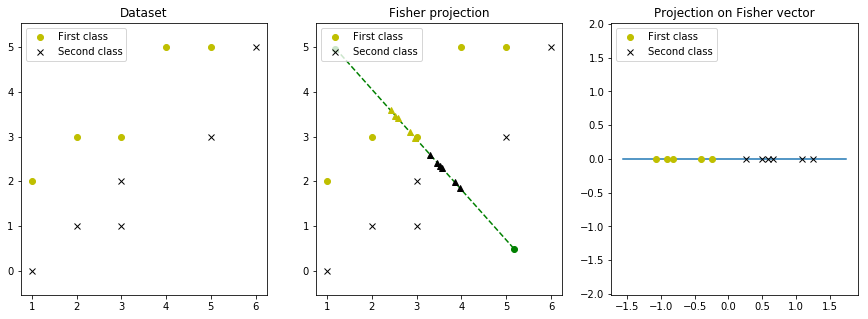

Предсказанные метки классов: 
 [[1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.]]
Вектор проекции W= [ 0.66555693 -0.74634708]


In [4]:
plt.rcParams["figure.figsize"]=[15,5]
X = np.array([[1, 2], [2, 3], [3, 3], [4, 5], [5, 5], [1, 0], [2, 1], [3, 1], [3, 2], [5, 3], [6, 5]]);
y = np.array([  [1],  [1],  [1],  [1],  [1],  [2],  [2],  [2],  [2],  [2],  [2]]); 
plt.axis('equal')
plt.subplot(131) #Dataset
plotData(X,y)
plt.title('Dataset')
plt.subplot(132) #Вектор Фишера для проектирования
VizFisherProject(y, X)
W, mu0_red, mu1_red, labels = FDACl(X,y)
ypred = FDApred(X,W, mu0_red, mu1_red, labels)
plt.subplot(133) #Классификация спроектированных данных
X_proj = FisherDataRed(X, W)
A = np.concatenate((X_proj, np.zeros((X_proj.shape[0],2))), axis = 1)
plt.plot([min(X_proj)-0.5, max(X_proj)+0.5], [0, 0] )
plt.title('Projection on Fisher vector')
plotData(A,y)
plt.show()
print ("Предсказанные метки классов: \n", ypred.T)
print ('Вектор проекции W=', W)



## Пример работы $FDA$ на Dataset 1: <a id="ex1"></a>

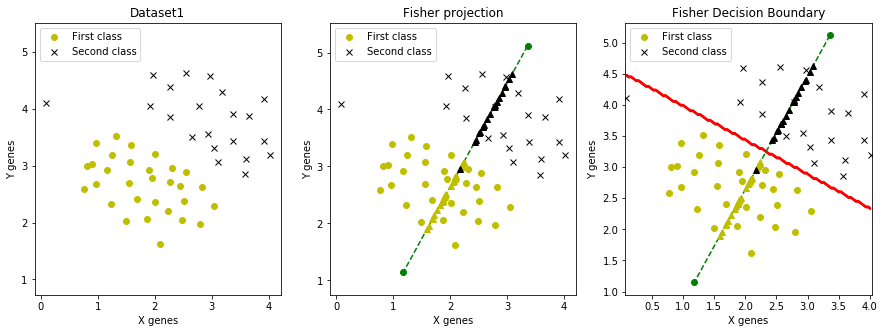

In [5]:
X, y = readmat('data1.mat')
plt.rcParams["figure.figsize"]=[15,5]
plt.axis('equal')

plt.subplot(131) #Dataset
plotData(X,y)
plt.xlabel('X genes')
plt.ylabel('Y genes')
plt.title('Dataset1')
plt.subplot(132) #Fisher projection
VizFisherProject(y, X)
plt.xlabel('X genes')
plt.ylabel('Y genes')
plt.subplot(133) # Рисуем кривую, разделяющую классы
plt.xlabel('X genes')
plt.ylabel('Y genes')
VizFisherProject(y, X)
plt.title('Fisher Decision Boundary')
VisFisherPred(y,X)
#fig =plt.figure()
plt.savefig('FDAex.pdf')

## CircleData. $FDA$ уже не справляется: <a id="c0"></a>
#### Расмотрим пример с  линейно неразделимым набором данных, на нем FDA работает плохо.

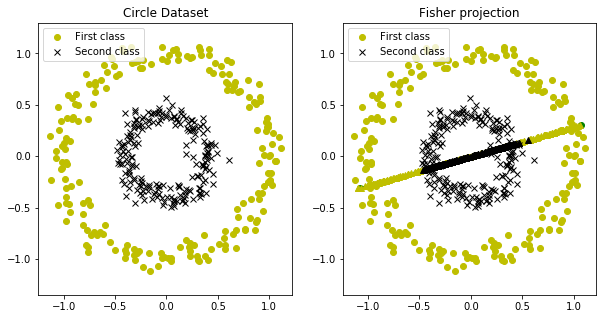

In [6]:
#Генерируем данные "кругового" вида
n = 400
plt.rcParams["figure.figsize"]=[10,5]
X, Y = make_circles(n_samples=n, noise=0.07, factor=0.4)
Y = np.array([Y]).T
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1) 
ax1.set_aspect('equal')
plotData(X,Y)
plt.title('Circle Dataset') 
ax1 = fig.add_subplot(1,2,2) #Находим вектор проектирования методом FDA
ax1.set_aspect('equal')
VizFisherProject(Y,X)

plt.savefig('Circle.pdf', bbox_inches = 'tight')


Для того чтобы применить к таким данным $FDA$ необходимо перейти в пространство большей размерности.

## Переход в пространство более высокой размерности <a id="c1"></a>
Попробуем решить задачу, перейдя из двухмерного пространства в трехмерное, например, с помощью функции: $$ F(x_1, x_2) = (x_1^1, x_2^2, \sqrt{2}x_1x_2) $$

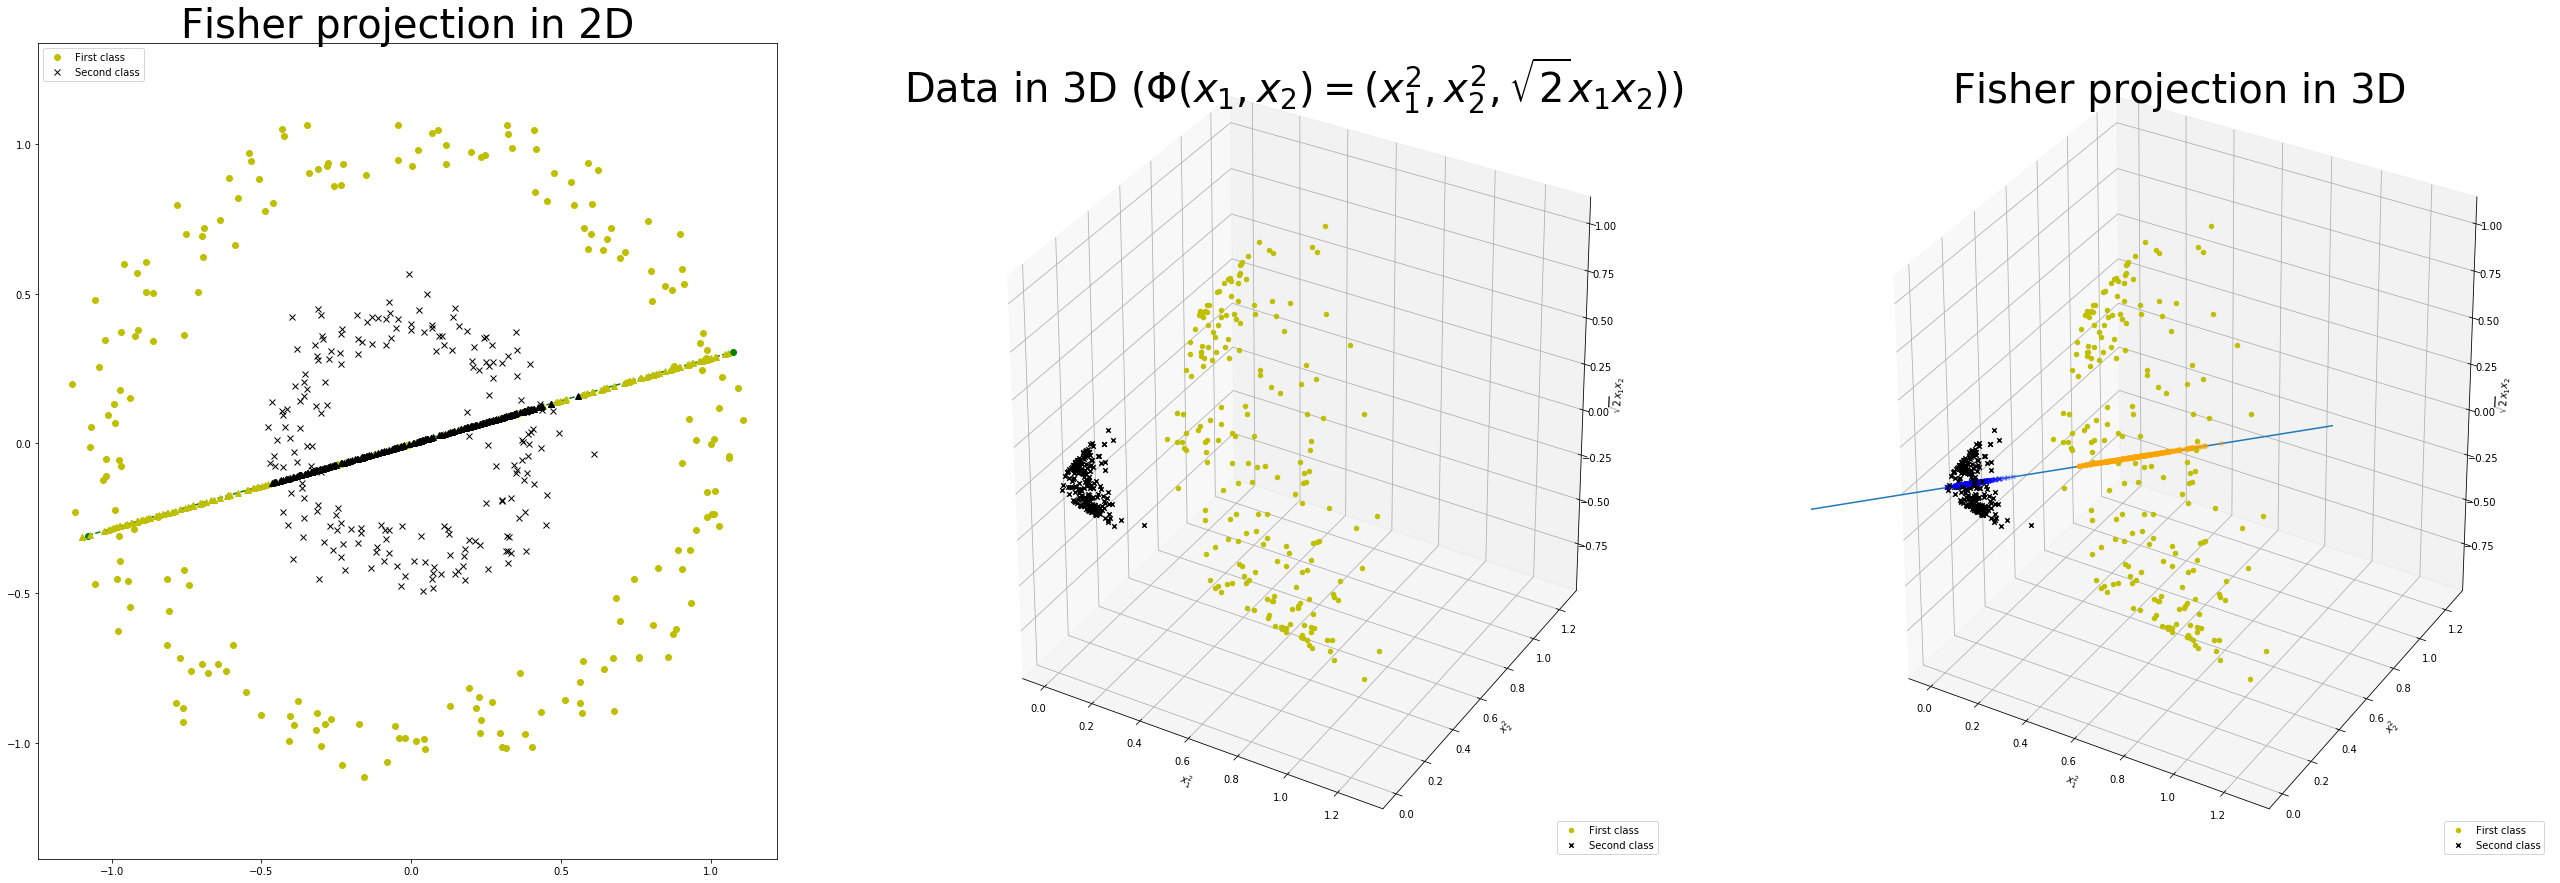

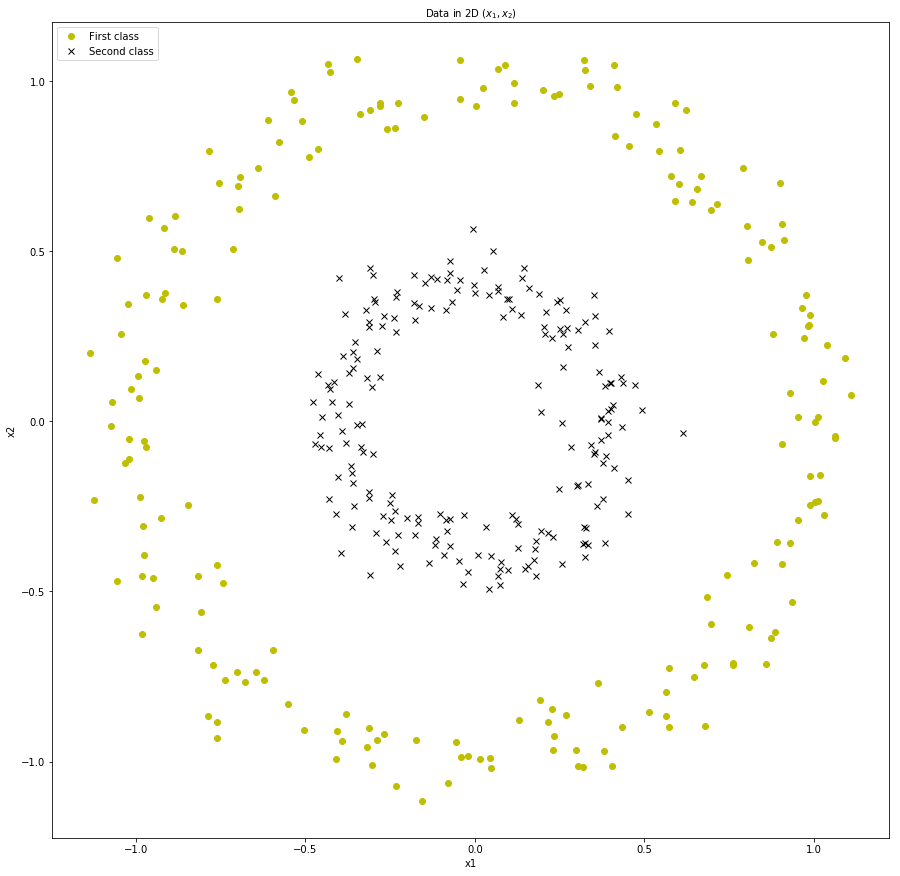

In [9]:
def DataToHigherSpace(X,Y): #Проецирем данные в пространство более высокой размерности
    ax.set_xlabel('$x_1^2$')
    ax.set_ylabel('$x_2^2$') 
    ax.set_zlabel('$\sqrt{2}x_1x_2$')
    X1 = np.zeros((X.shape[0], 3))
    for i in range (0, X.shape[0]):
        X1[i,0] = X[i,0]**2
        X1[i,1] = X[i,1]**2
        X1[i,2] = X[i,0]*X[i,1]*math.sqrt(2)
        if (Y[i] == 0):
            p1 =ax.scatter(X[i,0]**2, X[i,1]**2, X[i,0] * X[i,1]*math.sqrt(2), c = 'y', marker = 'o', label='First class')
        else:
            p2 = ax.scatter(X[i,0]**2, X[i,1]**2, X[i,0] * X[i,1]*math.sqrt(2), c = 'k', marker = 'x', label = 'Second class')
    plt.legend(handles = [p1, p2], loc = 4)
    return X1

plt.rcParams["figure.figsize"]=[45,15]
fig = plt.figure()
ax = fig.add_subplot(132, projection ='3d') 
plt.title("Data in 3D ($\Phi(x_1, x_2) = (x_1^2, x_2^2, \sqrt{2}x_1x_2)$)", fontsize = 40)
X1 = DataToHigherSpace(X,Y)
ax = fig.add_subplot(133, projection ='3d')
X1 = DataToHigherSpace(X,Y)
VisFisherProject3D(X1, Y)
plt.title('Fisher projection in 3D', fontsize = 40)
plt.subplot(1,3,1)
ax1.set_aspect('equal')
VizFisherProject(Y,X)
plt.title('Fisher projection in 2D', fontsize = 40) 
plt.savefig("Circlehighspace1.pdf")
plt.rcParams["figure.figsize"]=[15,15]
fig = plt.figure()
plotData(X,Y)
plt.title('Data in 2D ($x_1, x_2$)', fontsize = 10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("Circle1.pdf")


Видно, что в 3D данные уже легко линейно разделимы (можно провести плоскость, разделяющую классы). 
Kernel function, соответствующая такому переходу в пр-ве: $$k(x,y) = <\Phi(x), \Phi(y)> = <x, y>^2$$

## Реализуем $KFDA$: <a id="kfda"></a>

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
class KFDACl(BaseEstimator, ClassifierMixin): #Класс, для реализации KFDA
    def __init__(self, kernel = 'RBF', gamma = 'auto', c= None, d = None, Alg = 'SVM'):
        """    
               parameters:
               kernel - string, тип ядра: linear, Polynomial, RBF
               gamma - float, параметр RBF kernel. Если gamma = 'auto', то gamma = '1/n', где n - размерность пространства)
               c, d - int,  параметры Polynomial kernel(cвободный член и степень соответсвенно)
               Alg - string, способ классификации после понижения размерности: KNN, SVM
        """
        self.kernel = kernel
        self.gamma = gamma
        self.c = c
        self.d = d
        self.Alg = Alg

    def fit(self, X, y):
        """
        input:
               X - np.ndarray, матрица признаков объектов  nxk 
               y - np.array, вектор меток классов nx1 
        """
        if (self.gamma =='auto'):
            self.gamma = 1/(X.shape[1])
        self.labels_ = np.unique(y) # находим значение меток классов
        self.Cl_ = len(self.labels_) #Кол-во классов
        self.cl_ = [np.nonzero(y == self.labels_[i])[0] for i in range(0,self.Cl_)]
        Cl =self.Cl_
        K = self.Kernelmtrx(X, X) 
        #Разделяем образцы по классам
        Xcl = [X[self.cl_[i],:] for i in range(0,Cl)]
        #Кол-во образцов в каждом из классов
        ni = [Xcl[i].shape[0] for i in range (0,Cl)]
        n= sum(ni)
        #Вычисляем kernel matrix
        Ki = [K[:,np.nonzero(y == self.labels_[i])[0]] for i in range(0,Cl)]
        #Вычисляем Mi
        Mi = [np.mean(Ki[i], axis= 1) for i in range (0,Cl)]
        M0 = np.array([np.mean(K, axis=1)])
        M = np.zeros((n,n))
        for i in range (0,Cl):
            M = M + np.dot((M0-Mi[i]).T, M0-Mi[i])
        #Вычисляем Ni
        I = [np.eye(ni[i]) for i in range (0,Cl)]
        O = [1/float(ni[i]) for i in range (0,Cl)]
        T = [(I[i] - O[i]) for i in range (0, Cl)]
        Ni = [np.dot(Ki[i], np.dot(T[i], Ki[i].T)) for i in range (0, Cl)]
        #Добавляем mu (для регуляризации)
        eps=np.eye((n))
        eps = eps * 0.001
        N= sum(Ni) + eps
        e, v = np.linalg.eigh(M) #находим собственные значения и вектора M
        eps = np.ones(len(e))*abs(min(e))
        e = e + 2*eps
        sqrtE = [math.sqrt(x) for x in e]
        sqrtM =  np.dot(np.dot(v,np.diag(sqrtE)), np.matrix.transpose(v))
        S = np.dot(sqrtM, np.dot(np.linalg.inv(N), sqrtM))
        eigenValues, eigenVectors = scipy.linalg.eigh(S)
        self.alpha_ = np.zeros((eigenVectors.shape[0], Cl-1)) #alpha, вектор/матрица для проекции данных в расширенном простр-ве
        idx = eigenValues.argsort()[::-1] 
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        #alpha матрица для проекции, состоящая из Сl-1 собств векторов, соотв. Сl-1 наиб. собств. значениям матрицы S:
        for i in range (0, Cl):
            self.alpha_[:,i-1] =  np.dot(np.linalg.inv(sqrtM),eigenVectors[:, Cl-i-1])
        Z=np.dot(K,self.alpha_)
        # Значение образцов в проекции в Сl-1 пространство:
        self.X_red_ = Z.reshape(Z.shape[0],(Cl-1))
        self.Xtr_= X 
        # После понижения размерности, для спроектированных данных строим предсказательную модель:
        if (self.Alg == 'KNN'):
                
                PrModel = KNeighborsClassifier(n_neighbors=5)  
                PrModel.fit(self.X_red_, y)  
                self.PrModel_=PrModel
                print (PrModel.score(self.X_red_,y))         
                
        if (self.Alg == 'SVM'):
            if (self.Cl_ == 2): 
                PrModel= SVC(kernel = 'linear', probability =True)
            else:
                PrModel= SVC(probability =True)
            PrModel.fit(self.X_red_, y)
            self.PrModel_=PrModel
        return self
    def predict(self,Xtst):
        """
        input: Xtst - np.ndarray, матрица признаков объектов, для которых необх предсказать класс, mxk
        output:
               ypred - вектор предсказанный меток классов для объектов из Xpr, mx1
        """
        Cl = self.Cl_
        Kpr = self.Kernelmtrx(self.Xtr_, Xtst) 
        Xtst_red = np.dot(Kpr, self.alpha_) #Проектируем данные в уже найденное (в ф-ции fit) (Cl-1) мерное подпространство
        Xtst_red = Xtst_red.reshape(Xtst_red.shape[0],(Cl-1))
        ypred = np.zeros((Xtst_red.shape[0],1))
        #После проекции вектора в (Cl-1) мерное пространство определяем его к классу по построенной (в ф-ции fit)  предс модели:
        y_pred = self.PrModel_.predict(Xtst_red)  
        return y_pred
    def predict_proba(self, Xtst):
        Cl = self.Cl_
        Kpr = self.Kernelmtrx(self.Xtr_, Xtst) 
        w = self.alpha_
        Xtst_red = np.dot(Kpr, w) 
        Xtst_red = Xtst_red.reshape(Xtst_red.shape[0],(Cl-1)) 
        return self.PrModel_.predict_proba(Xtst_red)
    def decision_function(self, Xtst):
        Cl = self.Cl_
        Kpr = self.Kernelmtrx(self.Xtr_, Xtst) 
        w = self.alpha_
        Xtst_red = np.dot(Kpr, w) 
        Xtst_red = Xtst_red.reshape(Xtst_red.shape[0],(Cl-1)) 
        return self.PrModel_.decision_function(Xtst_red)
    def Kernelmtrx(self, Xtr, Xtst): #расчитывает kernel матрицу для векторов признаков 1ой группы объектов и 2ой, mxn
        """
        input: Xtr - матрица признаков 1ой группы объектов nxk
               Xtst - матрица признаков другой группы объектов mxk
        """ 
        K = np.zeros((Xtst.shape[0], Xtr.shape[0]))
        if (self.kernel == 'linear'):   #В случае linear kernel KFDA будет равносильно FDA
            return np.dot(Xtst, Xtr.T)
        if (self.kernel == 'RBF'):   #RBF kernel
            D = scipy.spatial.distance.cdist(Xtst, Xtr, 'sqeuclidean')
            K=exp(-0.5*D/(self.gamma*self.gamma))
            return K
        if (self.kernel =='Polynomial'): #K(x,y) = ((x, y.T) + b)^d
                if (self.c == None): 
                    print ("Введите свободный параметр c Polynomial Kernel")
                    self.c = int(input(),10)
                if (self.d == None): 
                    print ("Введите степень d Polynomial Kernel")
                    self.d = int(input(),10)
                K = (np.dot(Xtst, Xtr.T)+ self.c)**(self.d)
                return K
    def transform(self, Xtst , Proj): 
        """
        input: Xtst - np.ndarray, матрица признаков объектов, для которых необх. предсказать класс, mxk
               Proj - int, размерность подпространства, в которое проецируем: (Cl-1)<=Proj <=k
        output: Xtst_red -  данные Xtst, спроецированные  в подпространство из Proj "наилучших" векторов, найденных КFDA(fit)
               
        """
        Cl = self.Cl_
        Kpr = self.Kernelmtrx(self.Xtr_, Xtst) 
        w = self.alpha_[:,:Proj]
        Xtst_red = np.dot(Kpr, w) 
        Xtst_red = Xtst_red.reshape(Xtst_red.shape[0],Proj)
        return (Xtst_red)
    def score(self, X, y, k=5, t = 1, gamma = 0):
        """
        input: Xtst - np.ndarray, матрица тестовых объектов, mxk
               y - истинные значения меток тестовых объектов
        output: accuracy_score - float, ср. точность, с которой классификатор предсказывает метки классов
               
        """
        return accuracy_score(y, self.predict(X))

In [11]:
#Функция для физуализации работы KFDACl  в 2-ух мерном пространстве
def KFDAviz(X,y, kernel = 'RBF', sigma = 0.045, c = None, d = None):
    """
    input: X - матрица признаков объектов nx2
           y - вектор меток классов nx1
           sigma, c, d - параметр RBF kernel и параметры Polynomial kernel(свободный и степень) соответственно
           kernel - string, тип ядра: linear, Polynomial, RBF, Circle)
    output: Кривая, разделяющая объекты на классы в плоскости X[:,0]-X[:,1], 
                      найденная методом KFDA c заданным kernel  и пар-ром(sigma\ с,d)
    """
    x1pl=np.linspace(min(X[:,0]), max(X[:,0]), 100);
    x2pl=np.linspace(min(X[:,1]), max(X[:,1]), 100);
    [X1, X2] = np.meshgrid(x1pl, x2pl);
    vals = np.zeros((X1.shape[0], X1.shape[0]));
    X0 = np.zeros((X1.shape[0],2))
    cl = KFDACl(kernel, sigma, c, d)
    cl.fit(X,y)
    for i in range(0,X1.shape[1]):
        a = np.array([X1[:,i]])
        b = np.array([X2[:,i]])
        X0 = (np.concatenate((a,b), axis=0)).T
        M= cl.predict(X0)
        vals[:,i] = np.squeeze(np.asarray(M))
    #fig =plt.figure()
    cpf = plt.contour(X1,X2, vals, colors ='red')
    plotData(X,y)

## Применим к CircleData $KFDA$ с различными ядрами: <a id="c2"></a>

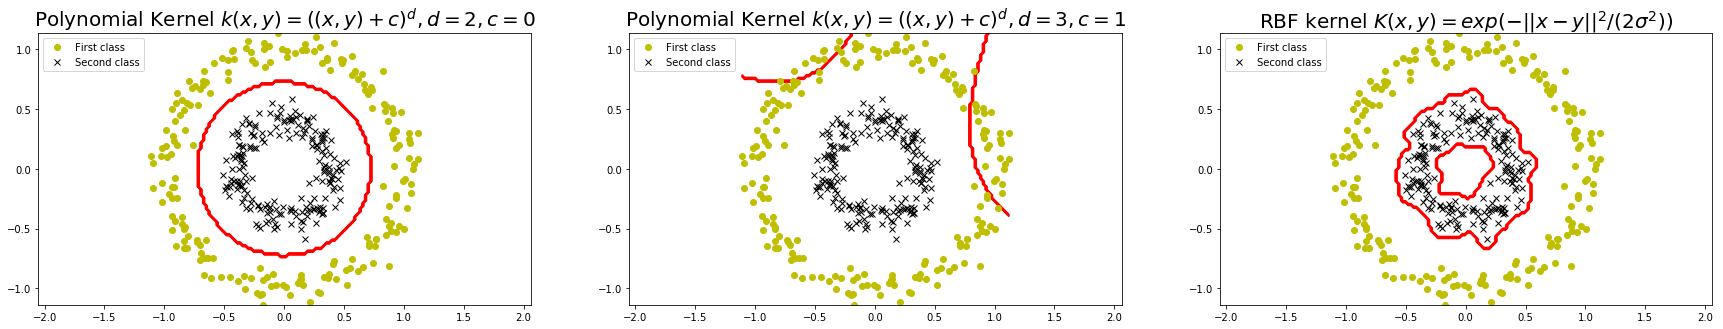

In [12]:
plt.rcParams["figure.figsize"]=[30,5]
n =400
X, Y = make_circles(n_samples=n, noise=0.07, factor=0.4)
Y = np.array([Y]).T
plt.subplot(131)
KFDAviz(X,Y, 'Polynomial', [], 0, 2)
plt.title('Polynomial Kernel $k(x,y) = ((x, y)+c)^d, d = 2, c = 0$', fontsize = 20)
plt.subplot(132)
KFDAviz(X,Y, 'Polynomial', [], 0, 3)
plt.title('Polynomial Kernel $k(x,y) = ((x, y)+c)^d, d = 3, c = 1$', fontsize = 20)
plt.subplot(133)
KFDAviz(X, Y, 'RBF')
plt.title('RBF kernel $K(x, y) = exp(-||x - y||^2/(2\sigma^2)$)' , fontsize = 20)
plt.savefig('CircleKernels.pdf', bbox_inches = 'tight')

##  KFDA на примере Toy Dataset

<a id="ex2"></a>

Разделим произвольно дату на тестовую и тренировочную в отношение 4:6 (тестовые данные выделены зеленым). И подадим алгоритму FDA/KFDA на вход только тестовые данные. По ним алгоритм поcтроит разделяющую классы кривую("сlassification decision boundary"). А по тестовым точкам мы сможем оценить правильность работы классификатора:

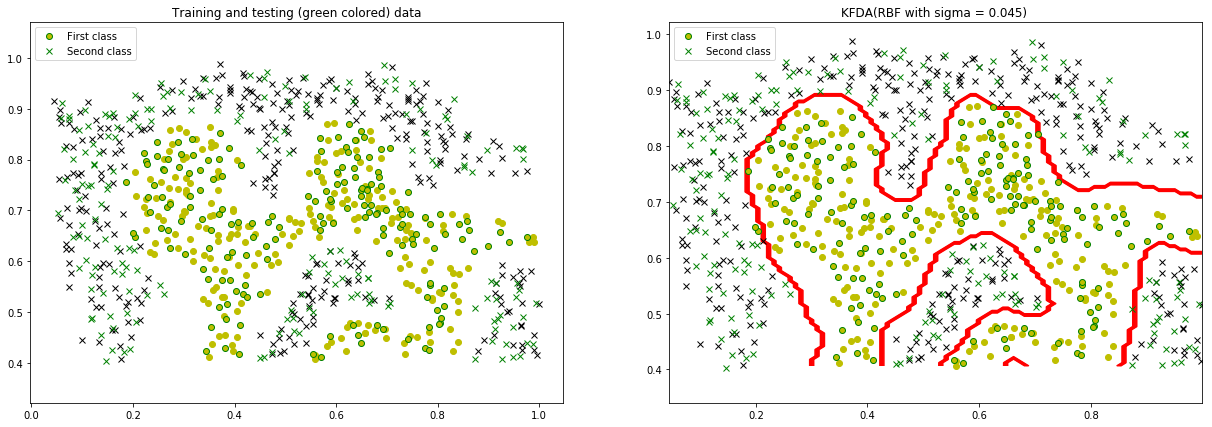

In [13]:
X, y = readmat('data2.mat')
plt.rcParams["figure.figsize"]=[21,7]
Xtr, Xtst, ytr, ytst = model_selection.train_test_split(X, y, test_size = 0.4)
plt.subplot(121)
plotData(Xtr,ytr)
plotData(Xtst, ytst, 'g')
plt.title('Training and testing (green colored) data')
plt.subplot(122)
plt.title('KFDA(RBF with sigma = 0.045) ')
KFDAviz(Xtr, ytr)
plotData(Xtst, ytst, 'g')
plt.savefig('KFDAtoydataset.pdf', bbox_inches = 'tight')

## Подбор оптимальных параметров ядра для RBF KFDA <a id="par0"></a>

#### RBF Kernel function: $K(x_i, x_j) = exp(\frac{-||x_i - x_j||^2}{2\sigma^2})$
#### Как подобрать наилучший параметр sigma для RBF ядра?
В примерах выше они определялись нами по умолчанию, заранее "удачно" подобранные. Далее будет применяться страндартный GridSearch для поиска наилучших параметров.
#### На самом деле,эти параметры играют важную роль. Изменив их, мы получим уже не такой точный классификатор. Вот, как работает KFDA на dataset2 при различнх параметрах ядра sigma: <a id="par1"></a>

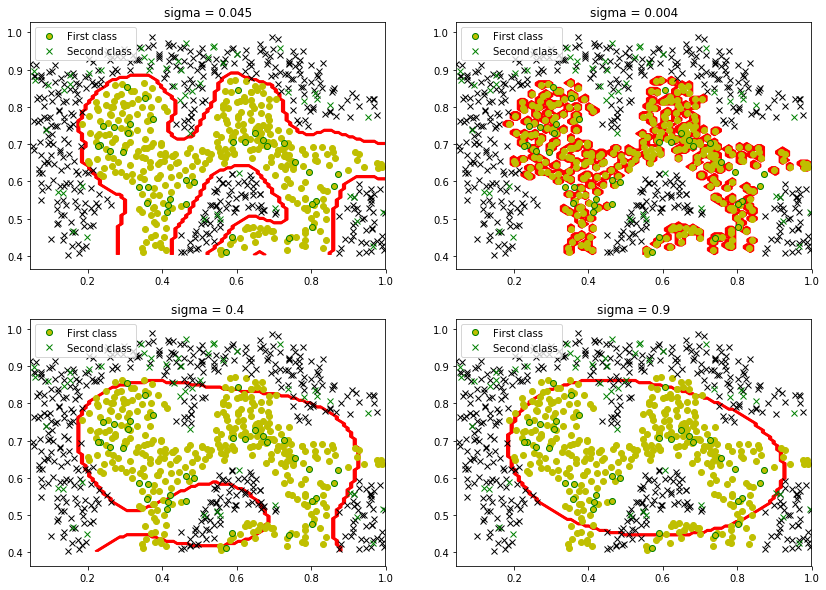

In [14]:
X, y = readmat('data2.mat')
Xtr, Xtst, ytr, ytst = model_selection.train_test_split(X, y, test_size = 0.1)
plt.rcParams["figure.figsize"]=[14,10]
par = [0.045, 0.004, 0.4, 0.9] #различные значения сигма
for i in range (1,5):
    plt.subplot(2,2, i)
    KFDAviz(Xtr, ytr, 'RBF', par[i-1])
    plotData(Xtst, ytst, 'g')
    plt.title('sigma = {}'.format(par[i-1]))
plt.savefig('KFDApar.pdf', bbox_inches = 'tight')

In [15]:
#Функция для подбора параметров(2 cпособа):
def bestPar(clf, X, y, gridtype = 2):
    if (gridtype==1):
        parameters = {"gamma": np.linspace(0.001, 10000, num = 1000000)}
        gr = RandomizedSearchCV(gr, parameters, n_iter =  10)
        gr.fit(X, y)
        return float(clf.best_params_['gamma'])
    if (gridtype==2):
        parameters = {"gamma": np.linspace(1/(X.shape[1]*10), 100, num = 100)}
        gr = GridSearchCV(clf, parameters)
        gr.fit(X, y)
        return (float(gr.best_params_['gamma']))


## Небинарный случай. Многоклассовая задача.
 KFDA легко обобщается на многоклассовый случай. Реализованнная нами функция KFDA может классифицировать данные из любого количества классов.

### Проверим работу многоклассового KFDA на примере IrisDataset(4-ех мерное пространство, три класса). <a id="multi0"></a>

Accuracy KFDA: 0.95 (+/- 0.07)
Accuracy FDA: 0.93 (+/- 0.06)


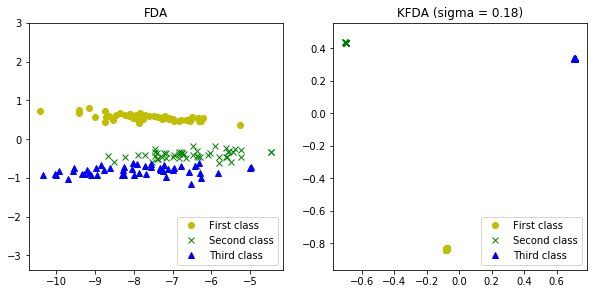

In [16]:
iris = datasets.load_iris()
X = iris.data[:,:]
y = iris.target
y = np.array([y]).T
#FDA
cl = KFDACl('linear')
cl.fit(X,y)
X_red=cl.X_red_
plt.rcParams["figure.figsize"]=[10,10]
plt.title('Результат работы FDA и KFDA на Iris Dataset:')
plt.subplot(2,2,1)
plotData(X_red,y, None, 'oy', 'xg', '^b' )
plt.title('FDA')
gamma = 0.18
cl = KFDACl(gamma = gamma )
cl.fit(X,y)
X_red=cl.X_red_
plt.subplot(2,2,2)
plotData(X_red,y, None, 'oy', 'xg', '^b' )
plt.title('KFDA (sigma = 0.18)')
plt.savefig('Iris.pdf', bbox_inches = 'tight')
scores = cross_val_score(KFDACl(gamma = gamma), X, y, cv=5)
print("Accuracy KFDA: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(KFDACl(kernel = 'linear'), X, y, cv=5)
print("Accuracy FDA: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#### А вот как выглядит неспроецированный Iris Dataset:

Пример объектов из Iris Dataset:
     sepal_length  sepal_width  petal_length  petal_width     species
0             5.1          3.5           1.4          0.2      setosa
15            5.7          4.4           1.5          0.4      setosa
30            4.8          3.1           1.6          0.2      setosa
45            4.8          3.0           1.4          0.3      setosa
60            5.0          2.0           3.5          1.0  versicolor
75            6.6          3.0           4.4          1.4  versicolor
90            5.5          2.6           4.4          1.2  versicolor
105           7.6          3.0           6.6          2.1   virginica
120           6.9          3.2           5.7          2.3   virginica
135           7.7          3.0           6.1          2.3   virginica


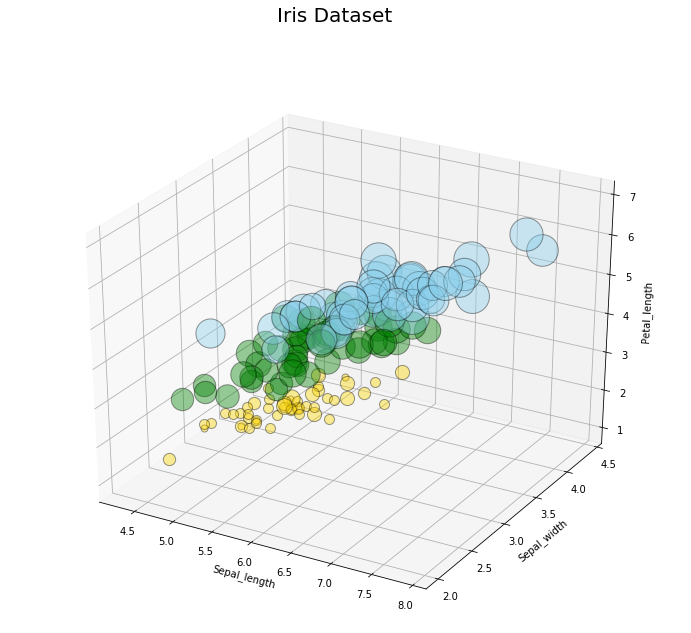

In [17]:
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
iris = sns.load_dataset("iris")
print ("Пример объектов из Iris Dataset:")
print (iris[::15])
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
t = fig.suptitle('Iris Dataset', fontsize=20)
xs = list(iris['sepal_length'])
ys = list(iris['sepal_width'])
zs = list(iris['petal_length'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
ss = list(iris['petal_width'])
colors = ['gold' if wt == 'setosa' else 'green' if wt == 'versicolor' else 'skyblue' for wt in list(iris['species'])]

for data, color, size in zip(data_points, colors, ss):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=size*500)
ax.set_xlabel('Sepal_length')
ax.set_ylabel('Sepal_width')
ax.set_zlabel('Petal_length')
plt.savefig('Iris4D.pdf', bbox_inches = 'tight')


## $ROC$-кривые <a id="roc"></a>
Для более точного анализа точности алгоритма, построим $ROC$-кривые для работы алгорима на различных данных и сравним с $ROC$-кривыми для классификатора $SVM$.

In [18]:
#Фунция дли рисования ROC кривых
def roc(cl, X,y,gamma='auto', svm = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
    if (gamma == 'auto'):
        if svm:
            parameters = {'C':(1,0.25,0.5,0.75),'gamma': np.linspace(0.001, 10000, num = 100)}
            gr = GridSearchCV(cl, parameters)
            gr.fit(X_train, y_train)
            cl.gamma = float(gr.best_params_['gamma'])
            cl.C= float(gr.best_params_['C'])
        else:
            cl.gamma = bestPar(cl, X_train, y_train)
    else:
        cl.gamma = gamma
    
    y_pred = cl.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, roc_auc



C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

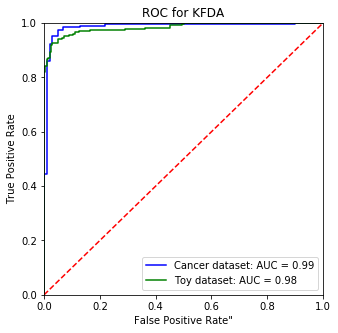

In [19]:
#Для бинарных данных
fpr = dict()
tpr = dict()
roc_auc = dict()
fig = plt.figure(figsize=(5, 5))
plt.title('ROC for KFDA')
X,y = get_data(datasets.load_breast_cancer())
fpr, tpr,roc_auc = roc(KFDACl(), X, y) 
plt.plot(fpr, tpr, 'b', label = 'Cancer dataset: AUC = %0.2f' % roc_auc)
X, y = readmat('data2.mat')
fpr, tpr,roc_auc = roc(KFDACl(), X, y, 0.25) 
plt.plot(fpr, tpr, 'g', label = 'Toy dataset: AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], '--r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate"')
plt.savefig("rocBinary0.pdf")

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

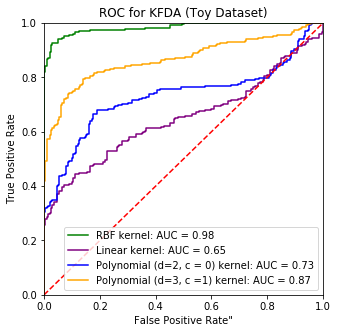

In [20]:
#Для toy dataset  с разными ядрами
fpr = dict()
tpr = dict()
roc_auc = dict()
fig = plt.figure(figsize=(5, 5))
plt.title('ROC for KFDA (Toy Dataset)')
X, y = readmat('data2.mat')
fpr, tpr,roc_auc = roc(KFDACl(), X, y, 0.25) 
plt.plot(fpr, tpr, 'g', label = 'RBF kernel: AUC = %0.2f' % roc_auc)
fpr, tpr,roc_auc = roc(KFDACl(kernel = 'linear'), X, y) 
plt.plot(fpr, tpr, 'purple', label = 'Linear kernel: AUC = %0.2f' % roc_auc)
fpr, tpr,roc_auc = roc(KFDACl(kernel = 'Polynomial', c=0,d = 2), X, y, gamma =0) 
plt.plot(fpr, tpr, 'b', label = 'Polynomial (d=2, c = 0) kernel: AUC = %0.2f' % roc_auc)
fpr, tpr,roc_auc = roc(KFDACl(kernel = 'Polynomial', c=1,d = 3), X, y, gamma =0) 
plt.plot(fpr, tpr, 'orange', label = 'Polynomial (d=3, c =1) kernel: AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], '--r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate"')
plt.savefig("rocBinary1.pdf")

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

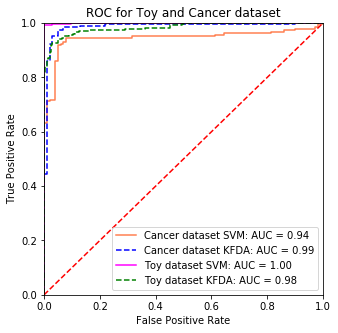

In [21]:
# В сравнение с другими классификаторами для бинарных датасетов, наш KFDA с наилучшими параметрами
fpr = dict()
tpr = dict()
roc_auc = dict()
fig = plt.figure(figsize=(5, 5))
X, y = get_data(datasets.load_breast_cancer())
fpr, tpr,roc_auc = roc(SVC(probability = True), X, y) 
plt.plot(fpr, tpr, 'coral', label = 'Cancer dataset SVM: AUC = %0.2f' % roc_auc)
fpr, tpr,roc_auc = roc(KFDACl(), X, y) 
plt.plot(fpr, tpr, '--b', label = 'Cancer dataset KFDA: AUC = %0.2f' % roc_auc)
X, y = readmat('data2.mat')
fpr, tpr,roc_auc = roc(SVC(probability = True), X, y, svm = True) 
plt.plot(fpr, tpr, 'fuchsia', label = 'Toy dataset SVM: AUC = %0.2f' % roc_auc)
fpr, tpr,roc_auc = roc(KFDACl(), X, y, 0.25) 
plt.plot(fpr, tpr, '--g', label = 'Toy dataset KFDA: AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], '--r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC for Toy and Cancer dataset')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROCbinarySVM.pdf')

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

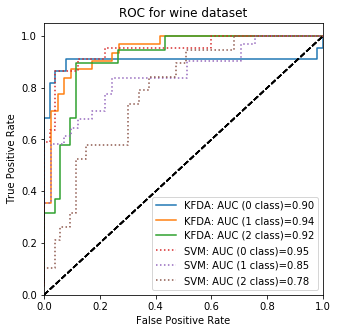

In [22]:
fig = plt.figure(figsize=(5, 5))
def draw_roc(clf, X, y, l = '-', types='KFDA', n_classes = 3 ):
    # Compute ROC curve and ROC area for each class
    # shuffle and split training and test sets
    y = label_binarize(y, classes=[i for i in range (0, n_classes)])
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.4, random_state=0)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linestyle =l, label=types+': AUC (%d class)' %i + '=%0.2f' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
X, y = get_data(datasets.load_wine())
gamma = bestPar(KFDACl(), X,y)
clf = OneVsRestClassifier(KFDACl(gamma = gamma))
draw_roc(clf,X,y, '-', 'KFDA' )
plt.title('ROC for wine dataset')
gamma = bestPar(SVC(), X,y)
clf = OneVsRestClassifier(SVC(gamma = gamma))
draw_roc(clf,X,y, ':', 'SVM' )
plt.savefig('ROCWineSVM1.pdf')

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

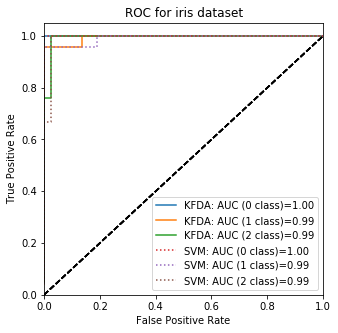

In [23]:
fig = plt.figure(figsize=(5, 5))
X, y = get_data(datasets.load_iris())
gamma = bestPar(KFDACl(), X,y)
clf = OneVsRestClassifier(KFDACl(gamma = gamma))
draw_roc(clf,X,y, '-', 'KFDA' )
plt.title('ROC for iris dataset')
gamma = bestPar(SVC(), X,y)
clf = OneVsRestClassifier(SVC(gamma = gamma))
draw_roc(clf,X,y, ':', 'SVM' )
plt.savefig('ROCIrisSVM1.pdf')

# Сравнительная таблица точности классификаторов  <a id="ac"></a>

In [24]:

def Accuracy(cl, X, y, gamma = 0): #KFDA и SVM
    cl.gamma = gamma
    scores = cross_val_score(cl, X, y, cv=5)
    return "%0.0f%% (+/- %0.1f%%)" % (100*scores.mean(), 100*scores.std() )
def Accuracy1(cl, X, y):
    scores = cross_val_score(cl, X, y, cv=5)
    return "%0.0f%% (+/- %0.1f%%)" % (100*scores.mean(), 100*scores.std() )

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
plotly.tools.set_credentials_file(username='nina666', api_key='qKeM0RTvyKnRSsIyZED4')
headerColor = 'grey'
rowEvenColor = 'orange'
rowOddColor = 'white'
Xt, yt = readmat('data2.mat')
Xi, yi = get_data(datasets.load_iris())
Xw, yw = get_data(datasets.load_wine())
Xb, yb = get_data(datasets.load_breast_cancer())
KFDA = KFDACl()
FDA = KFDACl(kernel = 'linear')
SVM = SVC()
KNN = KNeighborsClassifier()  
LDA = LDA()
QDA = QDA()
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
trace0 = go.Table(
  header = dict(
    values = [['<b>DATASETS</b>'],
                  ['<b>KFDA (RBF)</b>'],
                  ['<b>SVM (RBF)</b>'],
                  ['<b>FDA </b>'],
                  ['<b>KNN (k=5)</b>'],
                  ['<b>LDA</b>'],
                  ['<b>QDA</b>']],
    line = dict(color = '#506784'),
    fill = dict(color = headerColor),
    align = ['left','center'],
    font = dict(color = 'white', size = 12)
  ),

  cells = dict(
    values = [
      [['Toy', 'Breast Cancer', 'Iris', 'Wine']],
      [[Accuracy(KFDA,X = Xt,y=yt, gamma =0.045),Accuracy(KFDA,X = Xb,y=yb, gamma = bestPar(KFDA, Xb, yb)), Accuracy(KFDA,X = Xi,y=yi, gamma = bestPar(KFDA, Xi, yi)), Accuracy(KFDA,X = Xw,y=yw, gamma = bestPar(KFDA, Xw, yw))]],
      [[Accuracy(SVM,X = Xt,y=yt, gamma = bestPar(SVM, Xt, yt)),Accuracy(SVM,X = Xb,y=yb, gamma = bestPar(SVM, Xb, yb)), Accuracy(SVM,X = Xi,y=yi, gamma = bestPar(SVM, Xi, yi)), Accuracy(SVM,X = Xw,y=yw, gamma = bestPar(SVM, Xw, yw))]],
      [[Accuracy(FDA,X = Xt,y=yt),Accuracy1(LR,X = Xb,y=yb), Accuracy(FDA,X = Xi,y=yi), Accuracy1(LR,X = Xw,y=yw)]],
      [[Accuracy1(KNN,X = Xt,y=yt),Accuracy1(KNN,X = Xb,y=yb), Accuracy1(KNN,X = Xi,y=yi), Accuracy1(KNN,X = Xw,y=yw)]],
      [[Accuracy1(LDA,X = Xt,y=yt),Accuracy1(LDA,X = Xb,y=yb), Accuracy1(LDA,X = Xi,y=yi), Accuracy1(LDA,X = Xw,y=yw)]],
      [[Accuracy1(QDA,X = Xt,y=yt),Accuracy1(QDA,X = Xb,y=yb), Accuracy1(QDA,X = Xi,y=yi), Accuracy1(QDA,X = Xw,y=yw)]]],

    line = dict(color = '#506784'),
    fill = dict(color = [rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor, rowEvenColor]),
    align = ['left', 'center'],
    font = dict(color = '#506784', size = 11)
    ))


data = [trace0]

py.iplot(data, filename = "Accuracy2")


C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\ninak\Anaconda333\lib\site-packages\sklearn\uti